# Práctico Mabwiser

Adaptado de los tutoriales disponibles en: https://github.com/fidelity/mabwiser/tree/master/examples

## Reinforcement Learning

Un agente de RL busca tomar acciones que logren maximizar la ganancia acumulativa.

![RL setup](https://github.com/bamine/recsys-summer-school/raw/12e57cc4fd1cb26164d2beebf3ca29ebe2eab960/notebooks/images/rl-setup.png)


## Exploration vs. Exploitation

Se busca encontrar un balance entre la exploration (decidir tomar una acción para ganar conocimiento) y exploitation (decidir la acción que se calcula que tendrá la mejor ganancia).

![texto alternativo](https://miro.medium.com/max/1400/1*_5dltx4BcI8rRmCK2Sq_kw.png)

## Importar paquetes necesarios

In [1]:
!pip install mabwiser
# -*- coding: utf-8 -*-

import pandas as pd
from sklearn.preprocessing import StandardScaler

from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy

import random
from mabwiser.simulator import Simulator

from time import time

     |████████████████████████████████| 53 kB 1.5 MB/s 


## Problema con contexto:

Una plataforma de comercio virtual cuenta con 5 _ads_ y quiere determinar cuál de estos generará mayor _revenue_ para un usuario en específico. Para esto, se cuenta con información histórica de _revenues_ obtenidos por otros usuarios en distintos _ads_ junto con la información de la edad, la razón de clicks y si cada usuario es subscriptor o no.

In [2]:
# Arms
ads = [1, 2, 3, 4, 5]

# Historical data of ad decisions with corresponding revenues and context information
train_df = pd.DataFrame({'ad': [1, 1, 1, 2, 4, 5, 3, 3, 2, 1, 4, 5, 3, 2, 5],
                         'revenues': [10, 17, 22, 9, 4, 20, 7, 8, 20, 9, 50, 5, 7, 12, 10],
                         'age': [22, 27, 39, 48, 21, 20, 19, 37, 52, 26, 18, 42, 55, 57, 38],
                         'click_rate': [0.2, 0.6, 0.99, 0.68, 0.15, 0.23, 0.75, 0.17,
                                        0.33, 0.65, 0.56, 0.22, 0.19, 0.11, 0.83],
                         'subscriber': [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]}
                        )

# Test data to for new prediction
test_df = pd.DataFrame({'age': [37, 52], 'click_rate': [0.5, 0.6], 'subscriber': [0, 1]})
test_df_revenue = pd.Series([7, 13])

# Scale the training and test data
scaler = StandardScaler()
train = scaler.fit_transform(train_df[['age', 'click_rate', 'subscriber']].values.astype('float64'))
test = scaler.transform(test_df.values.astype('float64'))

In [3]:
########################################################
# KNearest Neighborhood Policy with UCB1 Learning Policy
########################################################

# KNearest context policy with k equals to 5 and ucb1 learning with alpha of 1.25
knearest = MAB(arms=ads,
               learning_policy=LearningPolicy.UCB1(alpha=1.25),
               neighborhood_policy=NeighborhoodPolicy.KNearest(k=5))

# Learn from previous ads shown and revenues generated
knearest.fit(decisions=train_df['ad'], rewards=train_df['revenues'], contexts=train)

# Predict the next best ad to show
prediction = knearest.predict(test)

# Expectation of each ad based on learning from past ad revenues
expectations = knearest.predict_expectations(test)

# Results
print("KNearest: ", prediction, " ", expectations)
assert(prediction == [5, 1])

# Online update of model
knearest.partial_fit(decisions=prediction, rewards=test_df_revenue, contexts=test)

# Updating of the model with new arm
knearest.add_arm(6)

KNearest:  [5, 1]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 16.5857953014744}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 10.242653222492628, 4: 0, 5: 7.242653222492627}]


### Actividad 1: 
Suponga que a este mismo usuario, se le presenta el nuevo _ad_, $6$, obteniendo un revenue de $40$. Usando el método _partial\_fit_ simule este caso e imprima las nuevas expectations. Comente los resultados obtenidos.

Al agregar este nuevo ad, con un revenue de 40, se puede ver que nuestro modelo predijo este nuevo ad para los dos usuarios. Esto se debe a que en la parte anterior el modelo había predecido los ads 5 y 1, con revenues de 16.58 y 24.24, para los dos usuarios respectivamente; y notamos que el ad 6 tiene un revenue mucho mayor, y por lo tanto, le convendría recomendarlo.

In [8]:
# actualizar el modelo segun el ad 6
knearest.partial_fit(decisions=[6,6], rewards=[40, 40], contexts=test)

prediction = knearest.predict(test)
expectations = knearest.predict_expectations(test)

print("KNearest: ", prediction, " ", expectations)

KNearest:  [6, 6]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 9.242653222492628, 6: 42.24265322249263}, {1: 19.0857953014744, 2: 22.242653222492628, 3: 0, 4: 0, 5: 7.242653222492627, 6: 42.24265322249263}]


## Problema sin contexto:

El sitio ahora quiere elegir entre dos posibles opciones de diseño para su _homepage_. Para esto tiene datos históricos del revenue aportado por cada diseño, pero no cuenta con ningún dato acerca de los usuarios.

In [20]:
# Arms
options = [1, 2]

# Historical data of layouts decisions and corresponding rewards
layouts = [1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1]
revenues = [10, 17, 22, 9, 4, 0, 7, 8, 20, 9, 50, 5, 7, 12, 10]

In [21]:
###################################
# Epsilon Greedy Learning Policy
###################################

# Epsilon Greedy learning policy with random exploration set to 15%
greedy = MAB(arms=options,
             learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
             seed=123456)

# Learn from previous layouts decisions and revenues generated
greedy.fit(decisions=layouts, rewards=revenues)

# Predict the next best layouts decision
prediction = greedy.predict()

# Expected revenues of each layouts learnt from historical data based on epsilon greedy policy
expectations = greedy.predict_expectations()

# Results
print("Epsilon Greedy: ", prediction, " ", expectations)
# assert(prediction == 1)

# Additional historical data becomes available which allows _online learning
additional_layouts = [1, 2, 1, 2]
additional_revenues = [0, 12, 7, 19]

# Online updating of the model
greedy.partial_fit(additional_layouts, additional_revenues)

Epsilon Greedy:  1   {1: 10.875, 2: 14.714285714285714}


### Actividad 2:
Suponga que en un experimento online, se le muestra a un usuario ambos diseños y el _revenue_ obtenido es exactamente el estimado por el agente. ¿Qué esperaría que pase al actualizar el modelo? Simule este caso en $5$ iteraciones, imprimiendo las expectations. Comente los resultados observados.

Lo que pasa es que el revenue que se predice no cambia. Esto se debe a que el modelo no puede saber si a un usuario le gusta más un homepage si es que lo que él piensa es lo mismo que "piensa" el modelo. No le está aportando información al modelo para saber cual es mejor o peor.

In [22]:
# Se imprime de nuevo debido a los nuevos datos que se agregaron
prediction = greedy.predict()
expectations = greedy.predict_expectations()
print("Epsilon Greedy: ", prediction, " ", expectations)


for i in range(5):
  greedy.partial_fit([1, 2], [expectations[1], expectations[2]])

  prediction = greedy.predict()
  expectations = greedy.predict_expectations()
  print("Epsilon Greedy: ", prediction, " ", expectations)

Epsilon Greedy:  2   {1: 9.4, 2: 14.88888888888889}
Epsilon Greedy:  2   {1: 9.4, 2: 14.88888888888889}
Epsilon Greedy:  2   {1: 9.4, 2: 14.888888888888888}
Epsilon Greedy:  2   {1: 9.400000000000002, 2: 14.888888888888888}
Epsilon Greedy:  2   {1: 9.400000000000002, 2: 14.888888888888888}
Epsilon Greedy:  2   {1: 9.400000000000002, 2: 14.888888888888888}


* Learning policies:
 * Epsilon Greedy
 * LinTS
 * LinUCB
 * Popularity
 * Random
 * Softmax
 * Thompson Sampling (TS)
 * Upper Confidence Bound (UCB1)

* Neighborhood Policies
 * Clusters
 * K-Nearest
 * LSH Nearest
 * Radius
 * TreeBandit

## Simulación:

Vamos a simular un multi-armed bandits para un dataset aleatorio con $1000$ entradas de datos y comparar los rendimientos de cada learning-policy:

In [28]:
size = 1000

decisions = [random.randint(0, 2) for _ in range(size)]
rewards = [random.randint(0, 1000) for _ in range(size)]
contexts = [[random.random() for _ in range(50)] for _ in range(size)]

In [29]:
####################################
# Different Bandits for Simulation
####################################

print('Starting simulation 1\n')


def binarize(decision, reward):

    return reward >= 500

n_jobs=2
contextual_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize),
                                            NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15),
                                         NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs))]

context_free_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), n_jobs=n_jobs)),
                     ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), n_jobs=n_jobs)),
                     ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize), n_jobs=n_jobs)),
                     ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15), n_jobs=n_jobs)),
                     ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), n_jobs=n_jobs))]

Starting simulation 1



2021-12-06 23:24:02,669 INFO Simulation Parameters
2021-12-06 23:24:02,669 INFO Simulation Parameters
2021-12-06 23:24:02,669 INFO Simulation Parameters
2021-12-06 23:24:02,673 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f2f4db988d0>), ('UCB1', <mabwiser.mab.MAB object at 0x7f2f4ee43350>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f2f4db98a10>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f2f4db98ad0>), ('Softmax', <mabwiser.mab.MAB object at 0x7f2f4db98b90>)]
2021-12-06 23:24:02,673 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f2f4db988d0>), ('UCB1', <mabwiser.mab.MAB object at 0x7f2f4ee43350>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f2f4db98a10>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f2f4db98ad0>), ('Softmax', <mabwiser.mab.MAB object at 0x7f2f4db98b90>)]
2021-12-06 23:24:02,673 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f2f4db988d0>), ('UCB1', <mabwiser.mab.MAB object at 0x7f2f4ee43350>), ('Thompson

Complete 0.01224518616994222 minutes


Random
Worst Case Scenario: {0: {'count': 269, 'sum': 41113, 'min': 7, 'max': 991, 'mean': 152.8364312267658, 'std': 280.66461750699773}, 1: {'count': 231, 'sum': 40644, 'min': 2, 'max': 996, 'mean': 175.94805194805195, 'std': 294.7610036104706}}
Average Case Scenario: {0: {'count': 269, 'sum': 137770.414893617, 'min': 25.0, 'max': 991.0, 'mean': 512.1576761844499, 'std': 169.1710691862077}, 1: {'count': 231, 'sum': 113406.36241610741, 'min': 15.0, 'max': 996.0, 'mean': 490.9366338359628, 'std': 181.5025274542095}}
Best Case Scenario: {0: {'count': 269, 'sum': 228790, 'min': 25, 'max': 1000, 'mean': 850.5204460966543, 'std': 285.1567568478944}, 1: {'count': 231, 'sum': 187460, 'min': 15, 'max': 996, 'mean': 811.5151515151515, 'std': 303.8252067619441}}



UCB1
Worst Case Scenario: {0: {'count': 500, 'sum': 78287, 'min': 4, 'max': 991, 'mean': 156.574, 'std': 271.78958133821095}, 1: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': nan, 'std

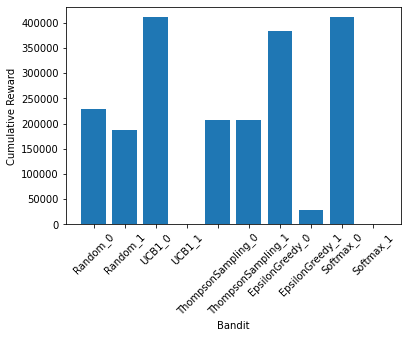

In [30]:
####################################
# Context-Free Simulation
####################################
start = time()
sim = Simulator(context_free_mabs, decisions, rewards, contexts=None,
                scaler=None, test_size=0.5, is_ordered=False, batch_size=0, seed=123456)
sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    print(mab_name)

    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name])

    print('\n\n')

sim.plot('max', True) 
# Vamos a plotear el best case scenario para todos los bandidos utilizados. El parámetro True indica que en el plot se va a plotear por separado cada "brazo"

### Actividad 3: Simulación "on-line" con contexto.

Basándose en el código anterior, vamos a repetir este experimento para los bandidos con contexto definidos anteriormente. Recuerde que los datos de contextos deben ser escalados, por lo que debe cambiar el parámetro scaler.

Esta simulación, a diferencia de la anterior, simulará un agente que se va actualizando de manera "on-line", en donde en cada iteración, los agentes reciben $100$ datos y en base a estos, actualizan sus políticas. Para hacer esto, solo debe modificar el parámetro de batch-size. Comente sus resultados

Al hacer esto, y realizar los distintos batches, notamos que la recompensa acumulativa va aumentando, lo cual es lo esperado ya que queremos que los modelos aprendan y mejorando la recompensa acumulada al ir viendo nuevos datos. 

2021-12-06 23:31:12,542 INFO Simulation Parameters
2021-12-06 23:31:12,542 INFO Simulation Parameters
2021-12-06 23:31:12,542 INFO Simulation Parameters
2021-12-06 23:31:12,542 INFO Simulation Parameters
2021-12-06 23:31:12,542 INFO Simulation Parameters
2021-12-06 23:31:12,542 INFO Simulation Parameters
2021-12-06 23:31:12,542 INFO Simulation Parameters
2021-12-06 23:31:12,554 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f2f4db98350>), ('UCB1', <mabwiser.mab.MAB object at 0x7f2f4db982d0>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f2f4db98590>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f2f4db98690>), ('Softmax', <mabwiser.mab.MAB object at 0x7f2f4db98790>)]
2021-12-06 23:31:12,554 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f2f4db98350>), ('UCB1', <mabwiser.mab.MAB object at 0x7f2f4db982d0>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f2f4db98590>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f2f4db98690>), ('Softmax', <mabw

Complete 0.2266006072362264 minutes


Random
Worst Case Scenario: {0: {'count': 273, 'sum': 38495, 'min': 4, 'max': 982, 'mean': 141.00732600732601, 'std': 252.74880017575882}, 1: {'count': 227, 'sum': 47323, 'min': 2, 'max': 993, 'mean': 208.4713656387665, 'std': 317.4573998537813}}
Average Case Scenario: {0: {'count': 273, 'sum': 134460.63768837246, 'min': 4.0, 'max': 982.0, 'mean': 492.5298083823167, 'std': 165.21347718539593}, 1: {'count': 227, 'sum': 118867.47197445531, 'min': 23.0, 'max': 993.0, 'mean': 523.6452509887899, 'std': 181.3848184586491}}
Best Case Scenario: {0: {'count': 273, 'sum': 222814, 'min': 4, 'max': 1000, 'mean': 816.1684981684982, 'std': 297.94903471235295}, 1: {'count': 227, 'sum': 187064, 'min': 23, 'max': 996, 'mean': 824.0704845814978, 'std': 280.0910556180081}}



UCB1
Worst Case Scenario: {0: {'count': 290, 'sum': 47895, 'min': 4, 'max': 984, 'mean': 165.1551724137931, 'std': 281.3761871234712}, 1: {'count': 210, 'sum': 42076, 'min': 2, 'max': 996, 'mean

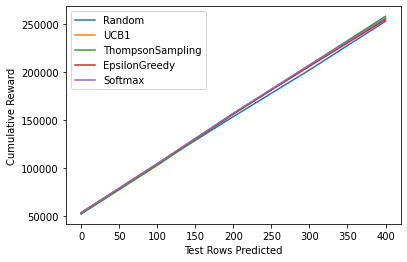

In [34]:
start = time()
# scaler =
# contexts = 
sim = Simulator(contextual_mabs, decisions, rewards, contexts=contexts,
                scaler=StandardScaler(), test_size=0.5, is_ordered=False, batch_size=100, seed=123456)
sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    print(mab_name)

    # Como esta simulación es online, se debe específicar que imprima el valor 'total'
    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name]['total'])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name]['total'])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name]['total'])

    print('\n\n')

sim.plot('avg', False)
# Como buscamos ahora maximizar el revenue, no separaremos los resultados por brazo, sino que se graficará de manera conjunta el revenue promedio obtenido por cada agente.